In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# data = pd.read_csv('processed_train.csv')
data = pd.read_csv('/content/drive/MyDrive/fulltrain.csv')

#train.columns = ['Labels','Text']
print(data.shape)
data.head()

(48854, 8)


,Label,Text,processed_text,tokens,ngrams,pos_tags,filtered_tokens,filtered_ngrams
0,1,"A little less than a decade ago, hockey fans w...",little less decade ago hockey fans blessed sla...,"['little', 'less', 'decade', 'ago', 'hockey', ...","[('little', 'less'), ('less', 'decade'), ('dec...","[('little', 'RB'), ('less', 'JJR'), ('decade',...","[('little', 'RB'), ('less', 'JJR'), ('ago', 'I...","[(('little', 'RB'), ('less', 'JJR')), (('less'..."
1,1,The writers of the HBO series The Sopranos too...,writers hbo series sopranos took another darin...,"['writers', 'hbo', 'series', 'sopranos', 'took...","[('writers', 'hbo'), ('hbo', 'series'), ('seri...","[('writers', 'NNS'), ('hbo', 'VBP'), ('series'...","[('hbo', 'VBP'), ('took', 'VBD'), ('another', ...","[(('hbo', 'VBP'), ('took', 'VBD')), (('took', ..."
2,1,Despite claims from the TV news outlet to offe...,despite claims tv news outlet offer news count...,"['despite', 'claims', 'tv', 'news', 'outlet', ...","[('despite', 'claims'), ('claims', 'tv'), ('tv...","[('despite', 'IN'), ('claims', 'NNS'), ('tv', ...","[('despite', 'IN'), ('tv', 'VBP'), ('offer', '...","[(('despite', 'IN'), ('tv', 'VBP')), (('tv', '..."
3,1,After receiving 'subpar' service and experienc...,receiving service experiencing unusually long ...,"['receiving', 'service', 'experiencing', 'unus...","[('receiving', 'service'), ('service', 'experi...","[('receiving', 'VBG'), ('service', 'NN'), ('ex...","[('receiving', 'VBG'), ('experiencing', 'VBG')...","[(('receiving', 'VBG'), ('experiencing', 'VBG'..."
4,1,After watching his beloved Seattle Mariners pr...,watching beloved seattle mariners prevail san ...,"['watching', 'beloved', 'seattle', 'mariners',...","[('watching', 'beloved'), ('beloved', 'seattle...","[('watching', 'VBG'), ('beloved', 'VBD'), ('se...","[('watching', 'VBG'), ('beloved', 'VBD'), ('se...","[(('watching', 'VBG'), ('beloved', 'VBD')), ((..."


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['Label'], test_size=0.2, random_state=1000)
y_train = [label - 1 for label in y_train]
y_test = [label-1 for label in y_test]

31314    go time declared russia syria iran new axis ev...
662      first date seemed going pretty well came scree...
25469    monsanto suing california telling people truth...
29881    passengers drivers deserve privacy protections...
29940    tv stations may start using military drones li...
                               ...                        
48379    central committee communist party china cpc st...
3776     press conference monday visibly embarrassed le...
6215     american sprinter justin gatlin recently annou...
4695     condemning decision dangerously reasonable bey...
42419    another night years later bono peered staples ...
Name: processed_text, Length: 39083, dtype: object

In [ ]:
import tensorflow as tf

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights

class PositionwiseFeedforward(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedforward, self).__init__()
        self.dense1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedforward(d_model, d_ff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

class TransformerEncoder(tf.keras.models.Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, dropout_rate=0.2,num_classes=4):
        super(TransformerEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, d_ff, dropout_rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.classification_head = ClassificationHead(num_classes)


    def call(self, inputs, training=None, mask=None):
        x = inputs
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)  # Pass mask as a keyword argument
        x = self.classification_head(x)
        return x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'd_ff': self.d_ff,
            'input_vocab_size': self.input_vocab_size,
            'maximum_position_encoding': self.maximum_position_encoding,
            'dropout_rate': self.dropout_rate,
            'num_classes': self.num_classes
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(tf.range(position)[:, tf.newaxis], tf.range(d_model)[tf.newaxis, :], d_model)

        # apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.math.pow(10000, (2 * tf.cast(i, tf.float32) / tf.cast(d_model, tf.float32)))
        pos = tf.cast(pos, tf.float32)  # Cast pos to float32
        return pos * angle_rates

class ClassificationHead(tf.keras.layers.Layer):
    def __init__(self, num_classes):
        super(ClassificationHead, self).__init__()
        self.num_classes = num_classes
        self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        x = x[:, 0, :]  # Take the <CLS> token representation
        x = self.dense(x)
        return x



In [ ]:
#max_length = int(100)
#max_length = int(50)
max_length = int(200)
batch_size = int(10)

# Tokenization
tokenizer = Tokenizer()
#tokenizer.fit_on_texts(train['Text'])
tokenizer.fit_on_texts(X_train)
# Instantiate the Transformer Encoder
num_layers = int(2)
d_model = int(32)
num_heads = int(4)
d_ff = int(64)
input_vocab_size = int(len(tokenizer.word_index) + 1)  # Add 1 for the reserved index 0
num_classes = 4
maximum_position_encoding = max_length

transformer_encoder = TransformerEncoder(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    input_vocab_size=input_vocab_size,
    maximum_position_encoding=maximum_position_encoding
)

# Generate batches of tokenized and padded sequences


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
def batch_generator(texts, labels, batch_size, tokenizer, max_length):
    num_samples = len(texts)
    num_batches = int(np.ceil(num_samples / batch_size))

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        print(f'Current Progress = {(start_idx/num_samples) * 100} %')
        batch_texts = texts[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Tokenization
        sequences = tokenizer.texts_to_sequences(batch_texts)

        # Padding
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

        yield padded_sequences,np.array(batch_labels)

train_generator = batch_generator(X_train,y_train, batch_size, tokenizer, max_length)

loss_values = []

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
transformer_encoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model using the fit method
num_epochs = 1
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for step, (batch_data, batch_labels) in enumerate(batch_generator(X_train, y_train, batch_size, tokenizer, max_length)):
        # Perform one training step
        with tf.GradientTape() as tape:
            logits = transformer_encoder(batch_data, training=True)
            batch_loss = loss(batch_labels, logits)
        gradients = tape.gradient(batch_loss, transformer_encoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer_encoder.trainable_variables))

        # Store the loss value
        loss_values.append(batch_loss.numpy())

        # Print loss for every few steps
        if step % 10 == 0:
            print(f"Batch {step + 1}, Loss: {batch_loss.numpy()}")
#history = transformer_encoder.fit(train_generator, epochs=num_epochs)

#generator = batch_generator(train['Text'],train['Labels'], batch_size, tokenizer, max_length)

# Example usage: Iterate over batches and feed them to the Transformer Encoder
#for batch in generator:
    #print("Batch shape:", batch.shape)
    #output = transformer_encoder(batch, training=True, mask=None)
    #print("Output shape:", output.shape)

Epoch 1/1
Current Progress = 0.0 %
Batch 1, Loss: 2.5442492961883545
Current Progress = 0.025586572166926794 %
Current Progress = 0.05117314433385359 %
Current Progress = 0.0767597165007804 %
Current Progress = 0.10234628866770717 %
Current Progress = 0.12793286083463398 %
Current Progress = 0.1535194330015608 %
Current Progress = 0.17910600516848757 %
Current Progress = 0.20469257733541435 %
Current Progress = 0.23027914950234118 %
Current Progress = 0.25586572166926796 %
Batch 11, Loss: 1.5669382810592651
Current Progress = 0.28145229383619474 %
Current Progress = 0.3070388660031216 %
Current Progress = 0.33262543817004836 %
Current Progress = 0.35821201033697514 %
Current Progress = 0.383798582503902 %
Current Progress = 0.4093851546708287 %
Current Progress = 0.4349717268377556 %
Current Progress = 0.46055829900468237 %
Current Progress = 0.48614487117160915 %
Current Progress = 0.5117314433385359 %
Batch 21, Loss: 1.4890011548995972
Current Progress = 0.5373180155054627 %
Current 

In [ ]:
new_generator = batch_generator(X_test,y_test, batch_size, tokenizer, max_length)

# Make predictions
predictions = transformer_encoder.predict(new_generator)

# Convert softmax probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=-1)

# Print predicted labels
# print("Predicted labels:", predicted_labels)

Current Progress = 0.0 %
Current Progress = 0.10234367004400778 %
Current Progress = 0.20468734008801556 %
      1/Unknown - 1s 943ms/stepCurrent Progress = 0.30703101013202333 %
Current Progress = 0.4093746801760311 %
      3/Unknown - 1s 44ms/step Current Progress = 0.5117183502200389 %
Current Progress = 0.6140620202640467 %
      5/Unknown - 1s 45ms/stepCurrent Progress = 0.7164056903080545 %
Current Progress = 0.8187493603520622 %
      7/Unknown - 1s 44ms/stepCurrent Progress = 0.9210930303960699 %
Current Progress = 1.0234367004400777 %
      9/Unknown - 1s 44ms/stepCurrent Progress = 1.1257803704840856 %
Current Progress = 1.2281240405280933 %
     11/Unknown - 1s 44ms/stepCurrent Progress = 1.330467710572101 %
Current Progress = 1.432811380616109 %
     13/Unknown - 1s 44ms/stepCurrent Progress = 1.5351550506601168 %
Current Progress = 1.6374987207041245 %
     15/Unknown - 2s 43ms/stepCurrent Progress = 1.7398423907481322 %
Current Progress = 1.8421860607921399 %
     17/Unkn

# Initial Matrix Dropout = 0.1

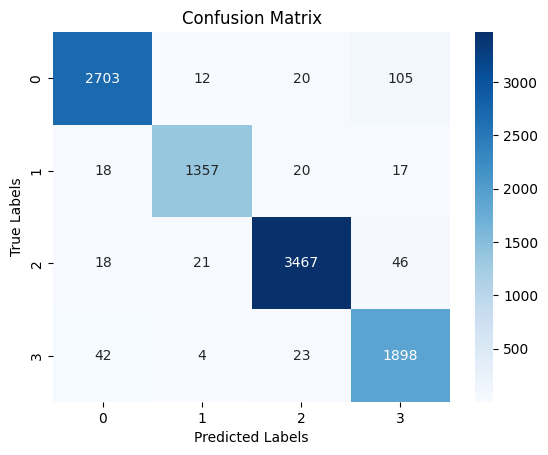

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Plot confusion matrix as heatmap

conf_matrix = confusion_matrix(y_test, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_test, predicted_labels))

print(f1_score(y_test, predicted_labels, average="macro"))


              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2840
           1       0.97      0.95      0.96      1412
           2       0.98      0.98      0.98      3552
           3       0.91      0.94      0.92      1967

    accuracy                           0.96      9771
   macro avg       0.95      0.95      0.95      9771
weighted avg       0.96      0.96      0.96      9771

0.9530879578679007


#New Matrix Dropout = 0.2

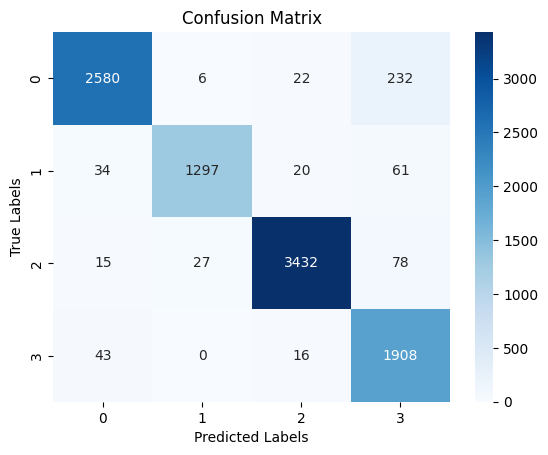

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Plot confusion matrix as heatmap

conf_matrix = confusion_matrix(y_test, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

[0.3174906373023987]

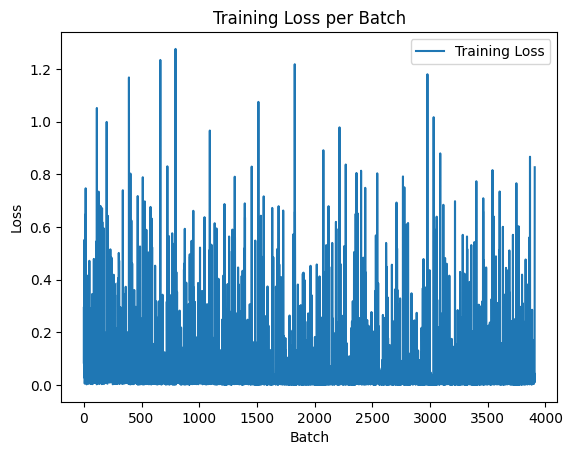

In [ ]:
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        return output, attention_weights

class PositionwiseFeedforward(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedforward, self).__init__()
        self.dense1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedforward(d_model, d_ff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

class TransformerEncoder(tf.keras.models.Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, dropout_rate=0.2, num_classes=4):
        super(TransformerEncoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.input_vocab_size = input_vocab_size
        self.maximum_position_encoding = maximum_position_encoding

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, d_ff, dropout_rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.classification_head = ClassificationHead(num_classes)

    def call(self, inputs, training=None, mask=None):
        input_text, input_new_column = inputs[0][:100], inputs[0][-1]  # Assuming inputs is a tuple of (text_data, new_column_data)
        print(f' input text dimension is {input_text.shape}')
        # Preprocess the new column data if necessary
        # new_column_data = preprocess_new_column(input_new_column)

        # Embedding and positional encoding for text data
        x_text = self.embedding(input_text)
        x_text *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        print(f'x_text shape is {x_text.shape}')
        print(f' tf shape is {tf.shape(input_text)}')
        print(f' output dimension is {self.positional_encoding(tf.shape(input_text), self.d_model).shape}')
        x_text += self.positional_encoding(tf.shape(input_text), self.d_model)

        # Process the new column data if necessary
        # x_new_column = process_new_column_data(new_column_data)

        # Concatenate text and new column data
        # x = tf.concat([x_text, x_new_column], axis=-1)

        # Pass through transformer layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x_text, training=training, mask=mask)  # Pass text data
            # Add processing for new column data if needed

        x = self.classification_head(x)
        return x


    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(tf.range(position)[:100, tf.newaxis], tf.range(d_model)[tf.newaxis, :], d_model)

        # Apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # Concatenate sin and cos arrays
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.math.pow(10000, (2 * tf.cast(i, tf.float32) / tf.cast(d_model, tf.float32)))
        pos = tf.cast(pos, tf.float32)  # Cast pos to float32
        return pos * angle_rates

class ClassificationHead(tf.keras.layers.Layer):
    def __init__(self, num_classes):
        super(ClassificationHead, self).__init__()
        self.num_classes = num_classes
        self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        x = x[:, 0, :]  # Take the <CLS> token representation
        x = self.dense(x)
        return x

# Example usage:
num_layers = 6
d_model = 512
num_heads = 8
d_ff = 2048
input_vocab_size = 10000
maximum_position_encoding = 1000
#dropout_rate = 0.1
dropout_rate = 0.2
num_classes = 10

transformer_encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, dropout_rate, num_classes)

# Optionally, you can compile the model and train it using fit method.



In [ ]:
def count_syllables_in_word(word):
    """
    Counts the syllables in a word. This is a simplified approach.
    """
    word = word.lower()
    syllables = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        syllables += 1
    for i in range(1, len(word)):
        if word[i] in vowels and word[i-1] not in vowels:
            syllables += 1
    if word.endswith("e"):
        syllables -= 1
    if syllables == 0:
        syllables = 1
    return syllables

def calculate_sentence_complexity(sentence):
    words = sentence.split()
    num_words = len(words)
    syllables = sum(count_syllables_in_word(word) for word in words)
    avg_word_length = sum(len(word) for word in words) / num_words
    avg_syllables_per_word = syllables / num_words
    # Simplified Flesch-Kincaid Readability Score for a single sentence
    fk_score = 206.835 - 1.015 * avg_word_length - 84.6 * avg_syllables_per_word

    # return {
    #     "Average Word Length": round(avg_word_length, 2),
    #     "Total Syllables": syllables,
    #     "Average Syllables per Word": round(avg_syllables_per_word, 2),
    #     "Simplified FK Score": round(fk_score, 2)
    # }
    return fk_score



In [ ]:
max_length = int(100)
batch_size = int(10)
num_layers = 6
d_model = 512
num_heads = 8
d_ff = 2048
input_vocab_size = int(len(tokenizer.word_index) + 1)
maximum_position_encoding = max_length
#dropout_rate = 0.1
dropout_rate = 0.2
num_classes = 10

transformer_encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_encoding, dropout_rate, num_classes)

tokenizer = Tokenizer()
#tokenizer.fit_on_texts(train['Text'])
tokenizer.fit_on_texts(X_train)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def batch_generator(texts, labels, batch_size, tokenizer, max_length):
    num_samples = len(texts)
    num_batches = int(np.ceil(num_samples / batch_size))

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        print(f'start is {start_idx},end is {end_idx}')
        batch_texts = texts[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Tokenization
        sequences = tokenizer.texts_to_sequences(batch_texts)

        # Padding
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

        complexities = [calculate_sentence_complexity(sentence) for sentence in batch_texts]

        numbers_to_add_array = np.array(complexities).reshape(-1, 1)
        result_array = np.concatenate((padded_sequences, numbers_to_add_array), axis=1)

        #yield padded_sequences,np.array(batch_labels)
        #print(result_array)
        yield result_array,np.array(batch_labels)

train_generator = batch_generator(X_train,y_train, batch_size, tokenizer, max_length)



optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
transformer_encoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model using the fit method
num_epochs = 1
history = transformer_encoder.fit(train_generator, epochs=num_epochs)

#generator = batch_generator(train['Text'],train['Labels'], batch_size, tokenizer, max_length)

# Example usage: Iterate over batches and feed them to the Transformer Encoder
#for batch in generator:
    #print("Batch shape:", batch.shape)
    #output = transformer_encoder(batch, training=True, mask=None)
    #print("Output shape:", output.shape)

start is 0,end is 10
 input text dimension is (100,)
x_text shape is (100, 512)
 tf shape is [100]
 output dimension is (1, 100, 512)
 input text dimension is (None,)
x_text shape is (None, 512)
 tf shape is Tensor("transformer_encoder_20/Shape:0", shape=(1,), dtype=int32)


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filew62l3z49.py", line 17, in tf__call
        ag__.ld(print)(f' output dimension is {ag__.converted_call(ag__.ld(self).positional_encoding, (ag__.converted_call(ag__.ld(tf).shape, (ag__.ld(input_text),), None, fscope), ag__.ld(self).d_model), None, fscope).shape}')
    File "/tmp/__autograph_generated_filecj5is1xr.py", line 10, in tf__positional_encoding
        angle_rads = ag__.converted_call(ag__.ld(self).get_angles, (ag__.converted_call(ag__.ld(tf).range, (ag__.ld(position),), None, fscope)[:100, ag__.ld(tf).newaxis], ag__.converted_call(ag__.ld(tf).range, (ag__.ld(d_model),), None, fscope)[ag__.ld(tf).newaxis, :], ag__.ld(d_model)), None, fscope)

    ValueError: Exception encountered when calling layer 'transformer_encoder_20' (type TransformerEncoder).
    
    in user code:
    
        File "<ipython-input-41-bb426ea94c03>", line 119, in call  *
            print(f' output dimension is {self.positional_encoding(tf.shape(input_text), self.d_model).shape}')
        File "<ipython-input-32-305d5f72d2c6>", line 138, in positional_encoding  *
            angle_rads = self.get_angles(tf.range(position)[:100, tf.newaxis], tf.range(d_model)[tf.newaxis, :], d_model)
    
        ValueError: Shape must be rank 0 but is rank 1
        	 for 'limit' for '{{node transformer_encoder_20/range}} = Range[Tidx=DT_INT32](transformer_encoder_20/range/start, transformer_encoder_20/Shape_1, transformer_encoder_20/range/delta)' with input shapes: [], [1], [].
    
    
    Call arguments received by layer 'transformer_encoder_20' (type TransformerEncoder):
      • inputs=tf.Tensor(shape=(None, None), dtype=float32)
      • training=True
      • mask=None


In [ ]:
"""new_generator = batch_generator(test, batch_size, tokenizer, max_length)

for batch in new_generator:
    predictions = transformer_encoder(batch, training=False, mask=None)
    print("Predictions shape:", predictions.shape)
    print("Predictions:", predictions)"""

start is 0,end is 10
Predictions shape: (9, 4)
Predictions: tf.Tensor(
[[1.5088434  0.5958586  0.59178764 1.9008746 ]
 [1.6295862  0.370853   0.8007204  2.0023282 ]
 [1.546447   0.5011424  0.5854096  1.7770933 ]
 [2.0661979  0.18093526 1.2569177  2.1465094 ]
 [1.8650881  0.37627578 0.90766895 2.703773  ]
 [1.7763923  0.17100936 1.199822   2.239289  ]
 [1.5473045  0.8649882  0.95779425 1.708171  ]
 [1.4876521  0.50929624 0.760877   2.2513251 ]
 [1.4768914  0.5168319  0.7661234  2.2509916 ]], shape=(9, 4), dtype=float32)


In [ ]:
history.history

{'loss': [0.3174906373023987], 'accuracy': [0.8807921409606934]}

,Unnamed: 0,Labels,Text,processed_text,tokens,ngrams,pos_tags,filtered_tokens,filtered_ngrams
0,0,1,"A little less than a decade ago, hockey fans w...",little less decade ago hockey fans blessed sla...,"['little', 'less', 'decade', 'ago', 'hockey', ...","[('little', 'less'), ('less', 'decade'), ('dec...","[('little', 'RB'), ('less', 'JJR'), ('decade',...","[('little', 'RB'), ('less', 'JJR'), ('ago', 'I...","[(('little', 'RB'), ('less', 'JJR')), (('less'..."
1,1,1,The writers of the HBO series The Sopranos too...,writers hbo series sopranos took another darin...,"['writers', 'hbo', 'series', 'sopranos', 'took...","[('writers', 'hbo'), ('hbo', 'series'), ('seri...","[('writers', 'NNS'), ('hbo', 'VBP'), ('series'...","[('hbo', 'VBP'), ('took', 'VBD'), ('another', ...","[(('hbo', 'VBP'), ('took', 'VBD')), (('took', ..."
2,2,1,Despite claims from the TV news outlet to offe...,despite claims tv news outlet offer news count...,"['despite', 'claims', 'tv', 'news', 'outlet', ...","[('despite', 'claims'), ('claims', 'tv'), ('tv...","[('despite', 'IN'), ('claims', 'NNS'), ('tv', ...","[('despite', 'IN'), ('tv', 'VBP'), ('offer', '...","[(('despite', 'IN'), ('tv', 'VBP')), (('tv', '..."
3,3,1,After receiving 'subpar' service and experienc...,receiving service experiencing unusually long ...,"['receiving', 'service', 'experiencing', 'unus...","[('receiving', 'service'), ('service', 'experi...","[('receiving', 'VBG'), ('service', 'NN'), ('ex...","[('receiving', 'VBG'), ('experiencing', 'VBG')...","[(('receiving', 'VBG'), ('experiencing', 'VBG'..."
4,4,1,After watching his beloved Seattle Mariners pr...,watching beloved seattle mariners prevail san ...,"['watching', 'beloved', 'seattle', 'mariners',...","[('watching', 'beloved'), ('beloved', 'seattle...","[('watching', 'VBG'), ('beloved', 'VBD'), ('se...","[('watching', 'VBG'), ('beloved', 'VBD'), ('se...","[(('watching', 'VBG'), ('beloved', 'VBD')), ((..."
5,5,1,"At a cafeteria-table press conference Monday, ...",press conference monday david pernell denied a...,"['press', 'conference', 'monday', 'david', 'pe...","[('press', 'conference'), ('conference', 'mond...","[('press', 'NN'), ('conference', 'NN'), ('mond...","[('denied', 'VBD'), ('recently', 'RB'), ('levi...","[(('denied', 'VBD'), ('recently', 'RB')), (('r..."
6,6,1,Stunned shock and dismay were just a few of th...,stunned shock dismay reactions bobby guntergra...,"['stunned', 'shock', 'dismay', 'reactions', 'b...","[('stunned', 'shock'), ('shock', 'dismay'), ('...","[('stunned', 'VBN'), ('shock', 'NN'), ('dismay...","[('stunned', 'VBN'), ('bobby', 'VBP'), ('learn...","[(('stunned', 'VBN'), ('bobby', 'VBP')), (('bo..."
7,7,1,"Speaking with reporters before a game Monday, ...",speaking reporters game monday local little le...,"['speaking', 'reporters', 'game', 'monday', 'l...","[('speaking', 'reporters'), ('reporters', 'gam...","[('speaking', 'VBG'), ('reporters', 'NNS'), ('...","[('speaking', 'VBG'), ('monday', 'RB'), ('loca...","[(('speaking', 'VBG'), ('monday', 'RB')), (('m..."
8,8,1,Sports journalists and television crews were p...,sports journalists television crews pushed asi...,"['sports', 'journalists', 'television', 'crews...","[('sports', 'journalists'), ('journalists', 't...","[('sports', 'NNS'), ('journalists', 'NNS'), ('...","[('pushed', 'VBD'), ('aside', 'RB'), ('super',...","[(('pushed', 'VBD'), ('aside', 'RB')), (('asid..."
9,9,1,"SALEM, VAF;or the eighth straight world-histor...",salem vaf eighth straight period sophomores ri...,"['salem', 'vaf', 'eighth', 'straight', 'period...","[('salem', 'vaf'), ('vaf', 'eighth'), ('eighth...","[('salem', 'NN'), ('vaf', 'NN'), ('eighth', 'J...","[('eighth', 'JJ'), ('straight', 'JJ'), ('river...","[(('eighth', 'JJ'), ('straight', 'JJ')), (('st..."
